In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Settings for better readability
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load data
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

# Quick overview
print(f'Dataset Size: {df.shape}')
display(df.head())

Dataset Size: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleaning & Type Conversion
`TotalCharges` is read as an object, but should be numeric. `customerID` is dropped as it has no predictive power.

In [11]:
# Drop ID
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric (coercing errors to NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values
print("Missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Drop rows with missing TotalCharges (very small % of data)
df.dropna(subset=['TotalCharges'], inplace=True)

# Simplify 'No internet service' to 'No' for consistency
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in service_cols:
    df[col] = df[col].replace('No internet service', 'No')

Missing values:
TotalCharges    11
dtype: int64


## Target Variable Analysis
Let's see if the dataset is balanced.

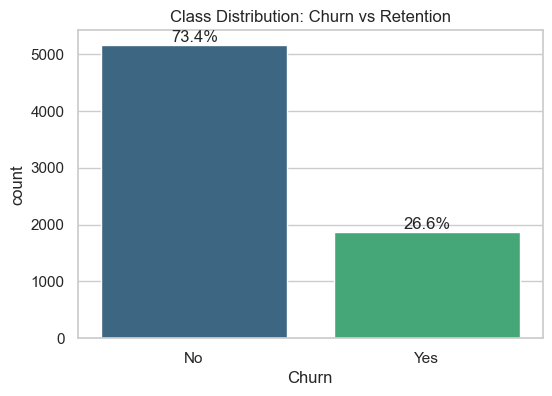

In [12]:
# Churn Distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df, palette='viridis', hue='Churn', legend=False)
plt.title('Class Distribution: Churn vs Retention')

# Annotate percentage
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + 0.3, p.get_height() + 50))

plt.show()

## Numerical Features Analysis
Let's look at `MonthlyCharges` and `tenure` to see if churned customers pay more.

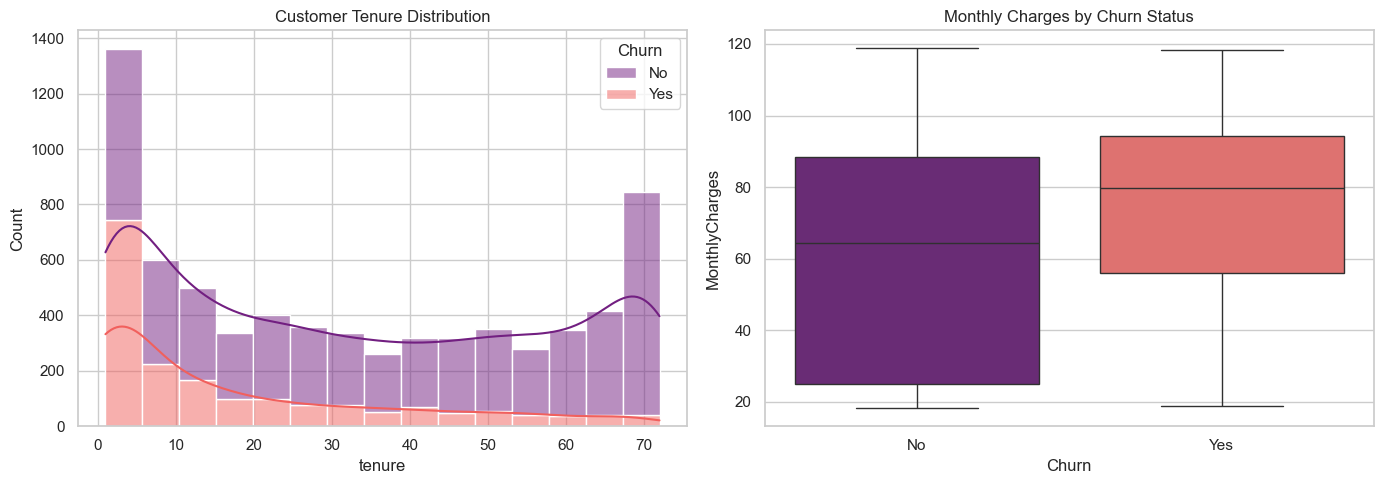

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tenure Distribution
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, ax=axes[0], palette='magma')
axes[0].set_title('Customer Tenure Distribution')

# Monthly Charges Boxplot
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1], palette='magma', hue='Churn', legend=False)
axes[1].set_title('Monthly Charges by Churn Status')

plt.tight_layout()
plt.show()

> 1. **Tenure:** We observe a "U-shape" behavior in the total distribution, but for churners (red), the peak is overwhelmingly at **0-5 months**. New customers are the most vulnerable.
> 2. **Monthly Charges:** There is a clear separation. The median monthly bill for churned customers is significantly higher (**~$80**) compared to retained customers (**~$65**). Higher bills correlate with higher churn.

## Categorical Features Analysis
How do contract type and internet service affect churn?

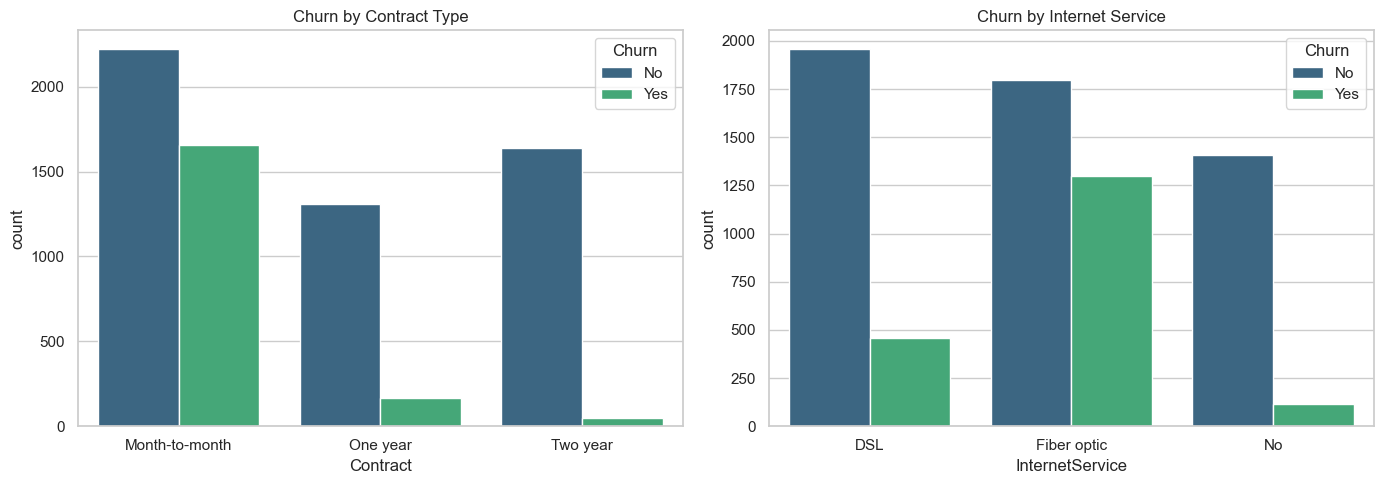

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contract Type
sns.countplot(x='Contract', hue='Churn', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Churn by Contract Type')

# Internet Service
sns.countplot(x='InternetService', hue='Churn', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Churn by Internet Service')

plt.tight_layout()
plt.show()

> 1. **Month-to-month** contracts have a massive churn rate compared to 1 or 2-year contracts.
> 2. **Fiber optic** users churn significantly more than DSL users (potential service quality issue?).

## Correlation Analysis
To calculate correlations, we need to encode categorical variables into numbers.

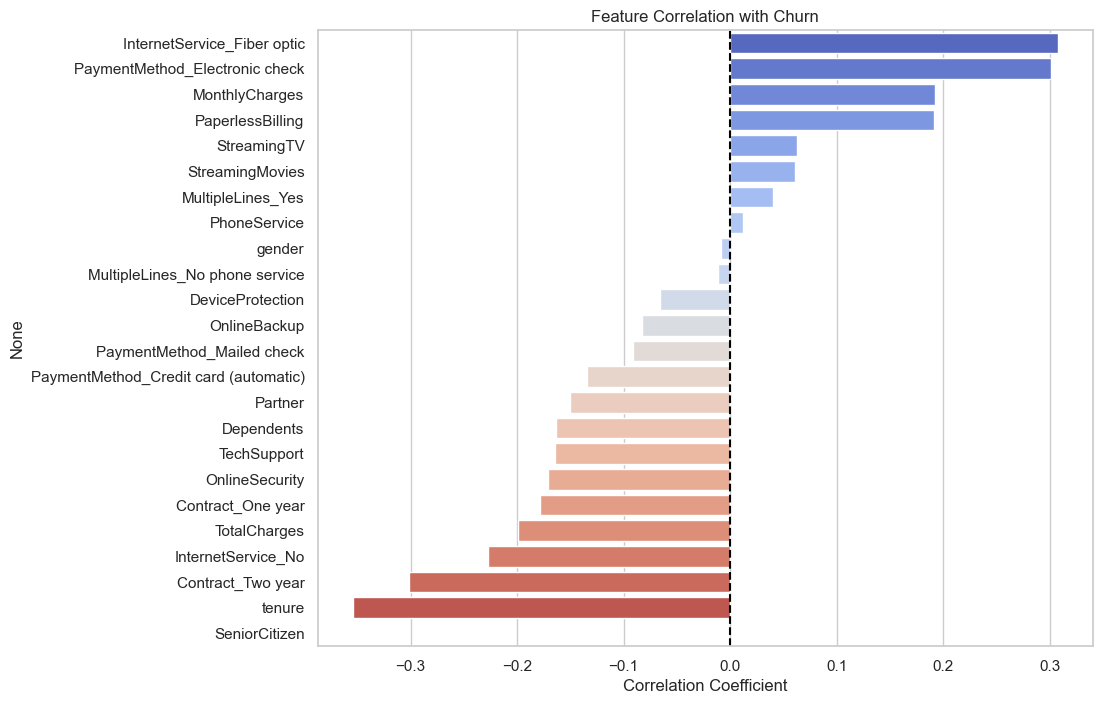

In [15]:
# Create a copy for correlation analysis
df_encoded = df.copy()

# Binary encoding
binary_cols = [c for c in df_encoded.columns if df_encoded[c].nunique() == 2]
for col in binary_cols:
    df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# One-Hot Encoding for remaining categorical variables
df_encoded = pd.get_dummies(df_encoded, drop_first=True)

# Calculate Correlation with Churn
churn_corr = df_encoded.corr()['Churn'].drop('Churn').sort_values(ascending=False)

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x=churn_corr.values, y=churn_corr.index, hue=churn_corr.index, palette='coolwarm', legend=False)
plt.title('Feature Correlation with Churn')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

## Summary & Conclusion

### Top Risk Factors (Positive Correlation):
1.  **Fiber Optic Internet:** The strongest visible positive driver (~0.30). Customers on this service are significantly more likely to leave.
2.  **Electronic Check:** The specific payment method associated with high churn.
3.  **Monthly Charges:** Higher costs relate directly to higher churn probability.

### Retention Drivers (Negative Correlation):
1.  **Tenure:** The strongest shield against churn (~ -0.35).
2.  **Two-year Contract:** Locking customers into long contracts massively reduces risk.
3.  **InternetService_No:** Customers without internet service are surprisingly loyal (or simply have fewer reasons to switch).

### Idea:
Focus retention efforts on **New Customers (0-6 months)** who select **Fiber Optic** and pay via **Electronic Check**. Consider incentivizing them to switch to **1-Year Contracts** or setting up auto-pay (Credit Card) to reduce friction.